Note:
    - remember you can do batch augmentation with BatchTransformCB()


In [1]:
'''
The 2d non-vae autoencoder
'''

'\nThe 2d non-vae autoencoder\n'

In [1]:
import torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.training import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

from  diy_stable_diffusion.attention import *

In [2]:
Dataset??

Init signature: Dataset(x, y)
Docstring:      <no docstring>
Source:        
class Dataset():
    def __init__(self, x, y):
        assert (len(x) == len(y))
        self.x=x
        self.y=y
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
    def __len__(self):
        return len(self.x)
File:           /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/training.py
Type:           type
Subclasses:     


In [3]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [73]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o) - 0.5 for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [74]:
dl = dls.valid
xb,yb = b = next(iter(dl))

In [5]:
def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Conv1d, nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(module.weight, a=0.2)

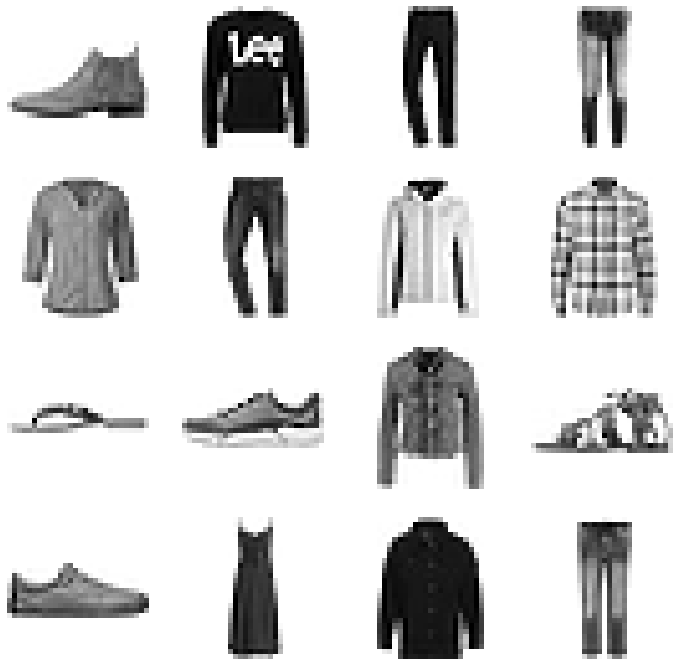

In [52]:
show_images(xb[:16])

In [63]:
def upblock(in_chans, out_chans, ks=3, act=act_genrelu, norm=None):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        ResBlock(in_chans, out_chans, ks=ks, act=act, norm=norm)
    )

In [12]:
from diy_stable_diffusion.utils import *

In [77]:
def get_model(act=act_genrelu, channels=(32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.1):
    layers = []
    n_layers=len(channels)
    layers.append(ResBlock(1, channels[0], ks=3, stride=1, act=act, norm=norm))
    for i in range(n_layers - 1):
        layers.append(ResBlock(channels[i], channels[i + 1], ks=3, stride=2, act=act, norm=norm))
        
    for i in range(n_layers - 1):
        layers.append(upblock(channels[n_layers-1-i], channels[n_layers-i-2], ks=3, act=act, norm=norm))
    
    layers.append(ResBlock(channels[0], 1, ks=3, stride=1, act=nn.Identity, norm=norm))
    return nn.Sequential(*layers).apply(init_weights)

In [11]:
epochs=10
lr=1e-3
tmax = epochs * len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MetricsCB(), ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=get_model()
opt=partial(optim.Adam, eps=1e-5)
learn=Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt)

loss,epoch,train
4.301,0,train
3.367,0,eval
2.271,1,train
1.368,1,eval
0.864,2,train
0.550,2,eval
0.423,3,train
0.337,3,eval
0.290,4,train
0.253,4,eval


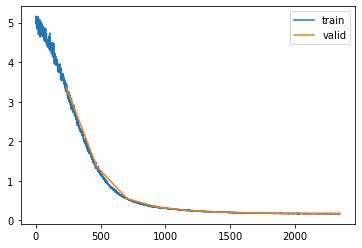

In [46]:
learn.fit(epochs)
saveobj(learn.model, 'autoenc2dfmnist')

In [13]:
model = torch.load('models/2024-01-27-autoenc2dfmnist-2c1c3104.pkl')

In [21]:
xb.shape

torch.Size([256, 1, 32, 32])

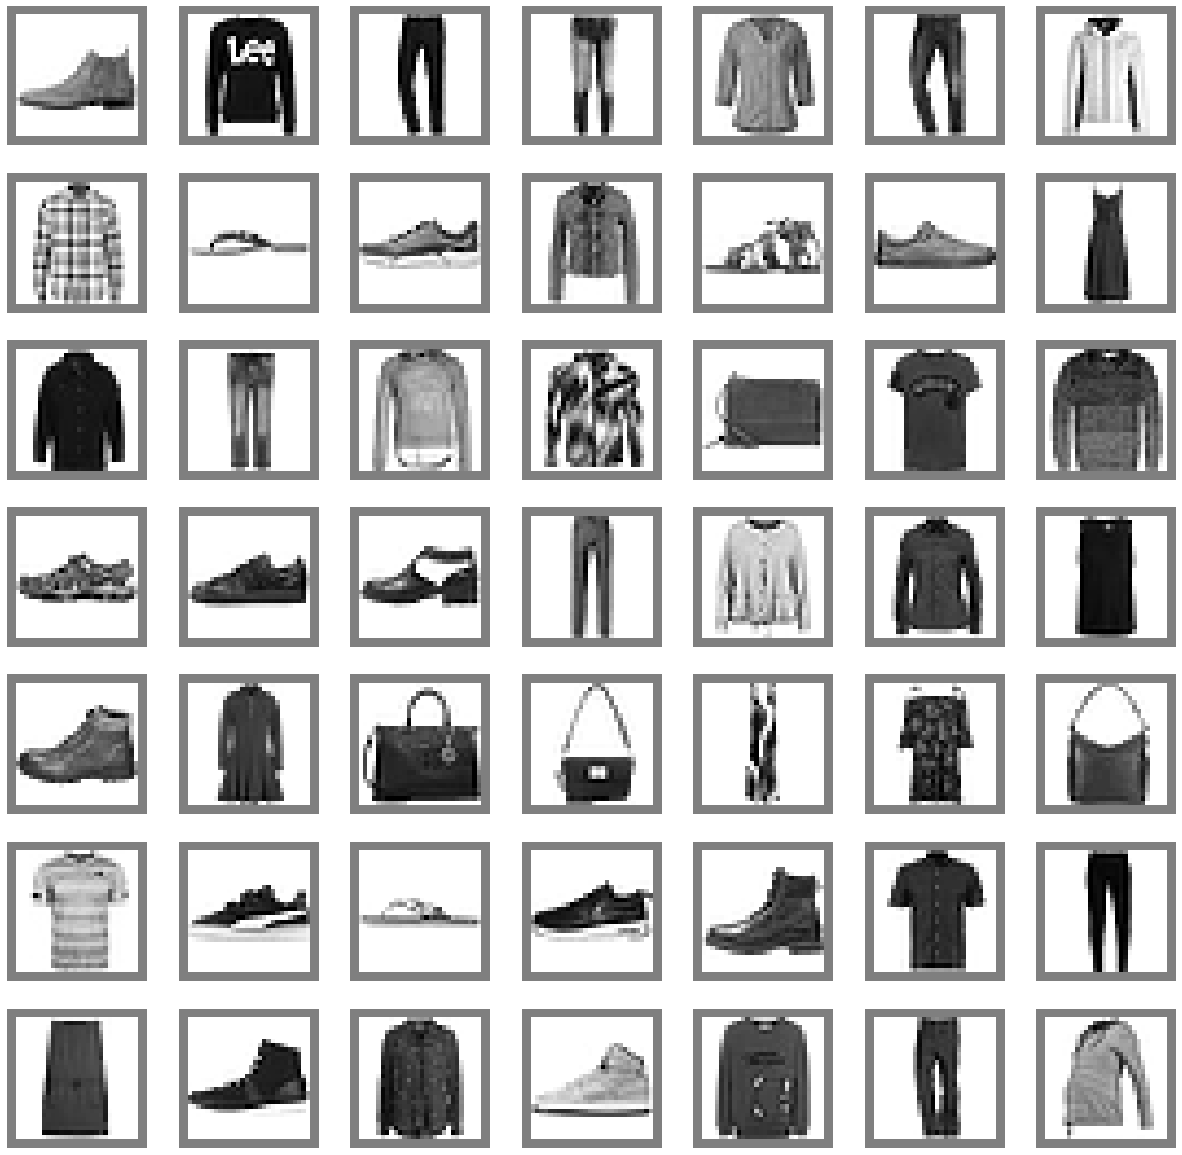

In [27]:
show_images(xb[:49])

In [23]:
result=model(xb.cuda())

In [24]:
result.shape

torch.Size([256, 1, 32, 32])

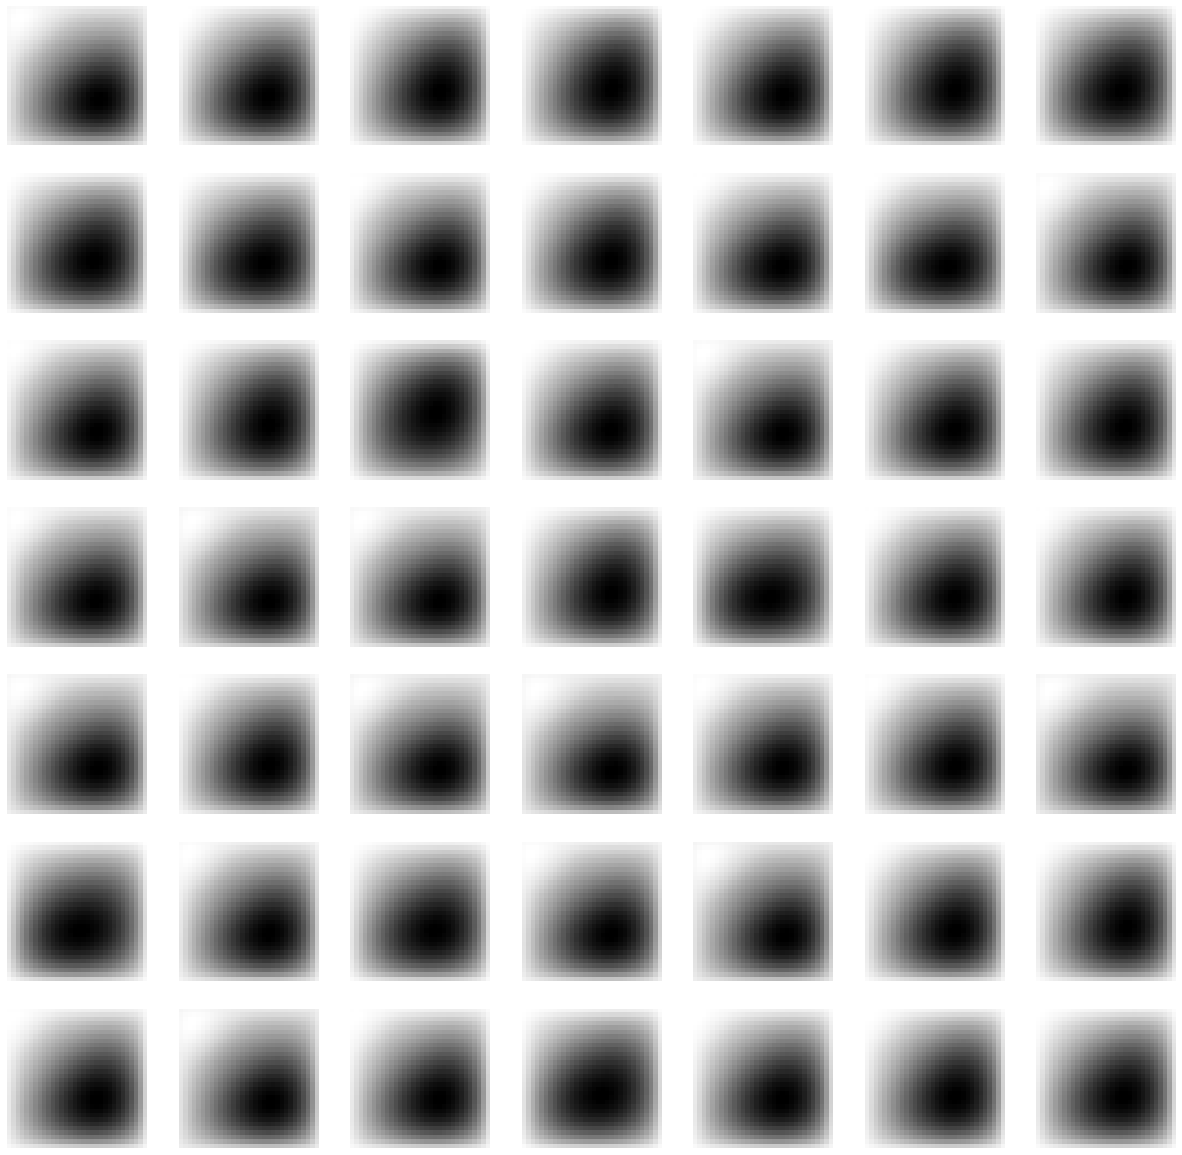

In [25]:
show_images(result.cpu()[:49])

In [28]:
model

Sequential(
  (0): ResBlock(
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): 

In [29]:
model[:5]

Sequential(
  (0): ResBlock(
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (block): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): 

In [31]:
model[5:]

Sequential(
  (5): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): ResBlock(
      (block): Sequential(
        (0): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralRelu()
        )
        (1): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): GeneralRelu()
    )
  )
  (6): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): ResBlock(
      (block): Sequential(
        (0): Sequential(
          (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2

In [32]:
encoder = model[:5]

In [33]:
decoder = model[5:]

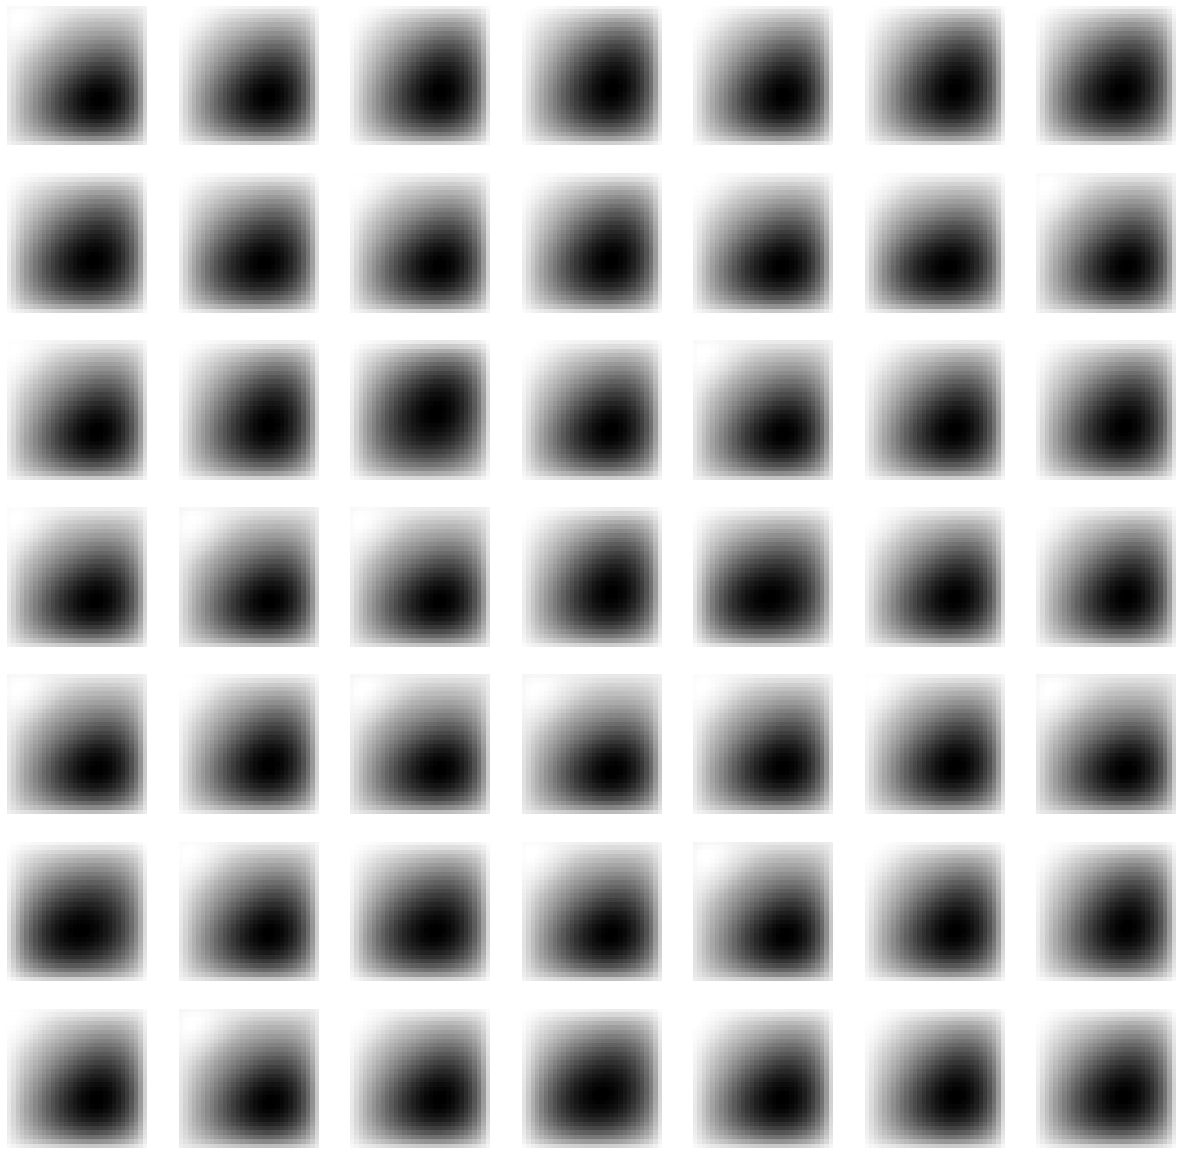

In [35]:
show_images(decoder(encoder(xb[:49].cuda())).cpu())

In [36]:
encoded = encoder(xb.cuda())
encoded.shape

torch.Size([256, 512, 2, 2])

In [53]:
epochs=5
tmax = epochs * len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MetricsCB(), ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=get_model(channels=(4, 4, 4))
opt=partial(optim.Adam, eps=1e-5)

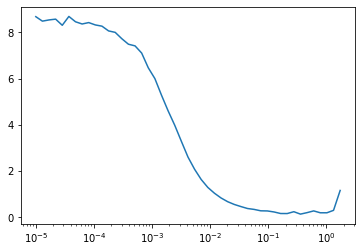

In [54]:
Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()

In [55]:
lr=3e-1

In [56]:
learn=Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt)

loss,epoch,train
0.178,0,train
0.030,0,eval
0.021,1,train
0.018,1,eval
0.015,2,train
0.015,2,eval
0.014,3,train
0.013,3,eval
0.013,4,train
0.013,4,eval


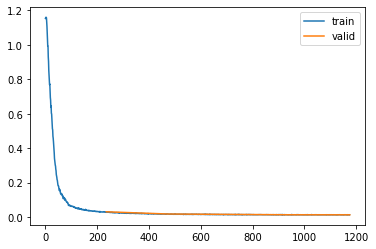

In [57]:
learn.fit(epochs)
saveobj(learn.model, 'autoenc2dfmnist-smallchans')

In [73]:
yb.min(), yb.max()

(tensor(-0.5000), tensor(0.5000))

In [58]:
res = model(xb.cuda())

In [59]:
res.shape

torch.Size([256, 1, 28, 28])

In [65]:
res.min(), res.max(), res.median()

(tensor(-0.8436, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.0637, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.4168, device='cuda:0', grad_fn=<MedianBackward0>))

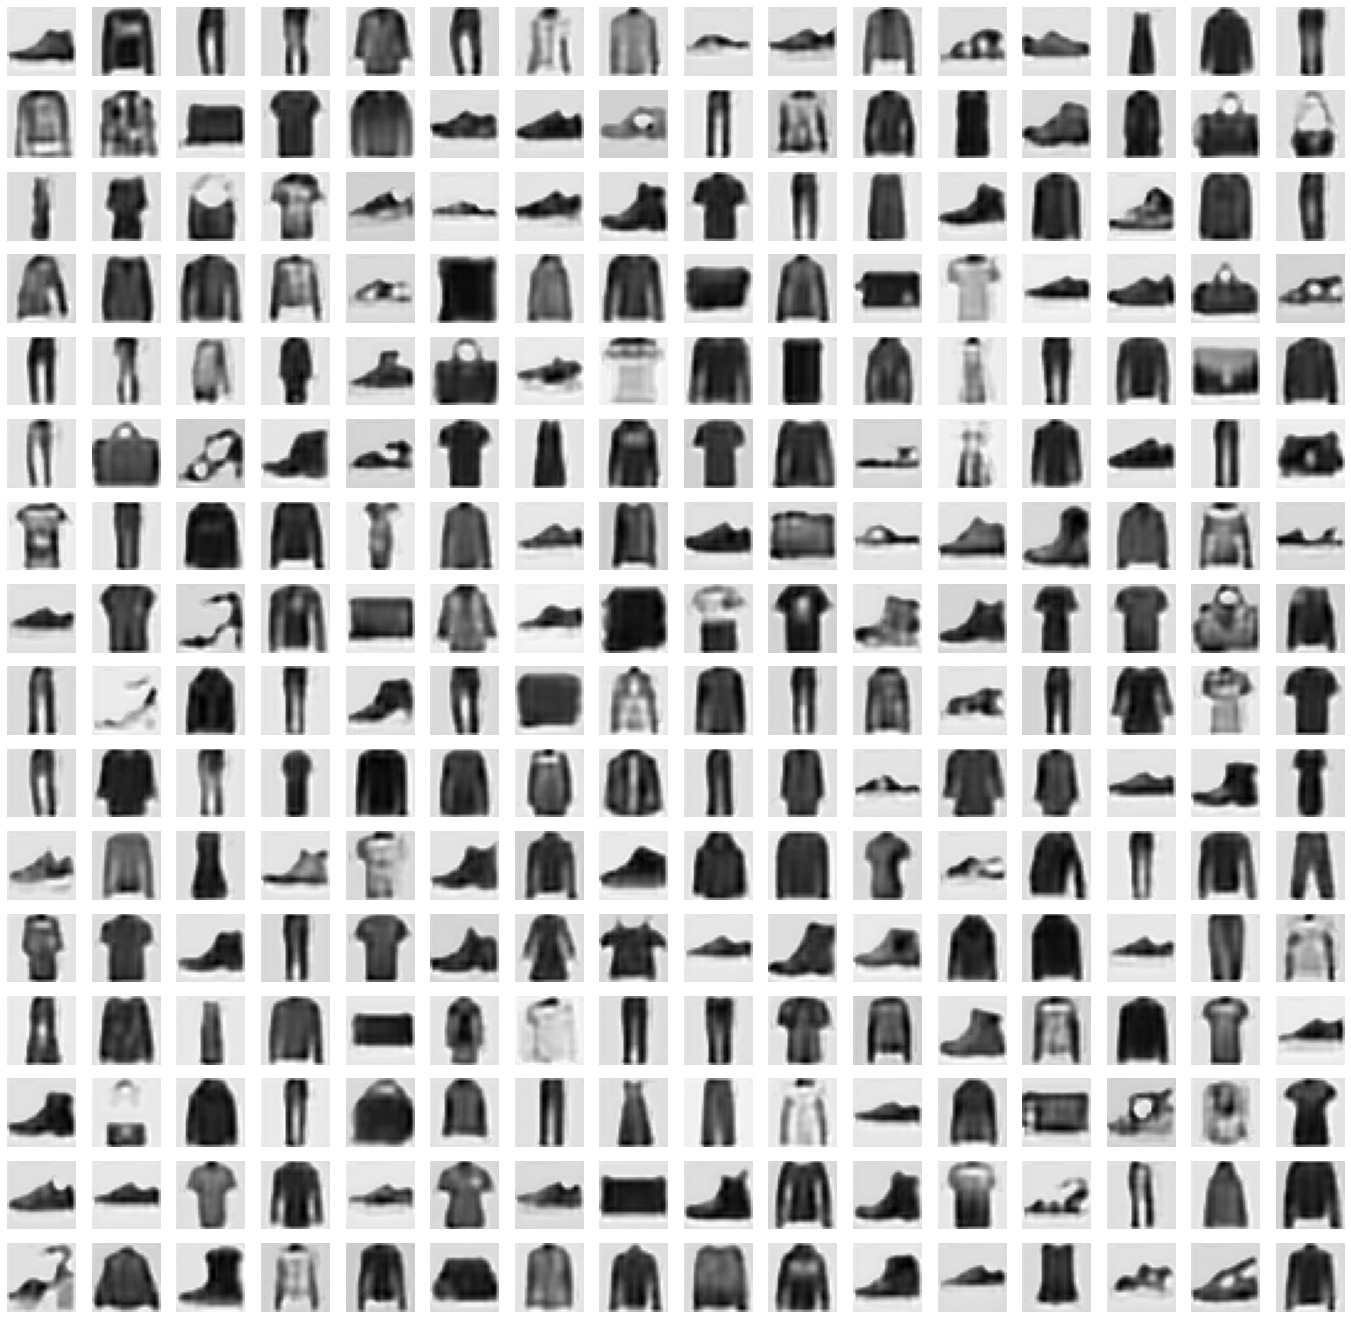

In [74]:
show_images(res.cpu() * 2, imsize=1.5)

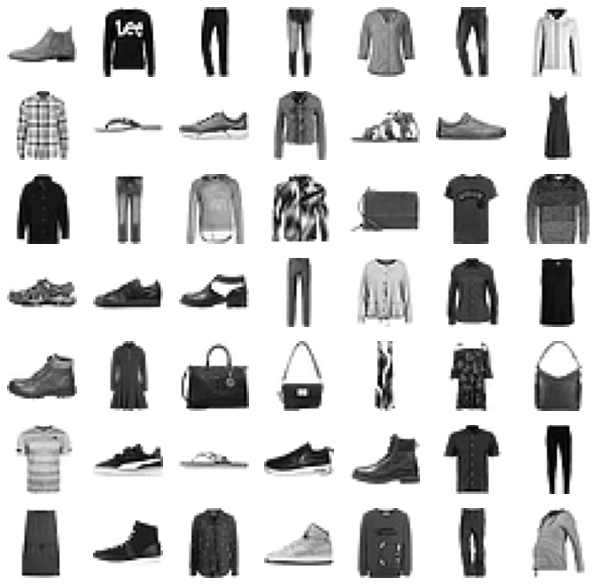

In [63]:
show_images(xb[:49].cpu() , imsize=1.5)

## try again descending channels?

In [80]:
epochs=5
tmax = epochs * len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MetricsCB(), ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=get_model(channels=(6, 5, 4))
init_weights(model)
opt=partial(optim.Adam, eps=1e-5)

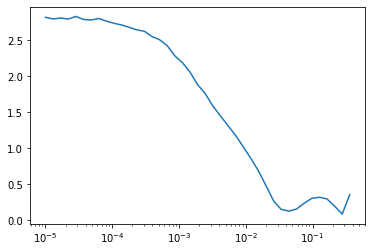

In [81]:
Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()

In [82]:
lr=3e-2

In [83]:
learn=Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt)

loss,epoch,train
0.025,0,train
0.029,0,eval
0.010,1,train
0.011,1,eval
0.007,2,train
0.010,2,eval
0.006,3,train
0.005,3,eval
0.005,4,train
0.005,4,eval


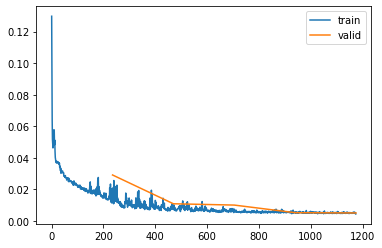

In [84]:
learn.fit(epochs)

In [90]:
res=model(xb.cuda()).cpu()

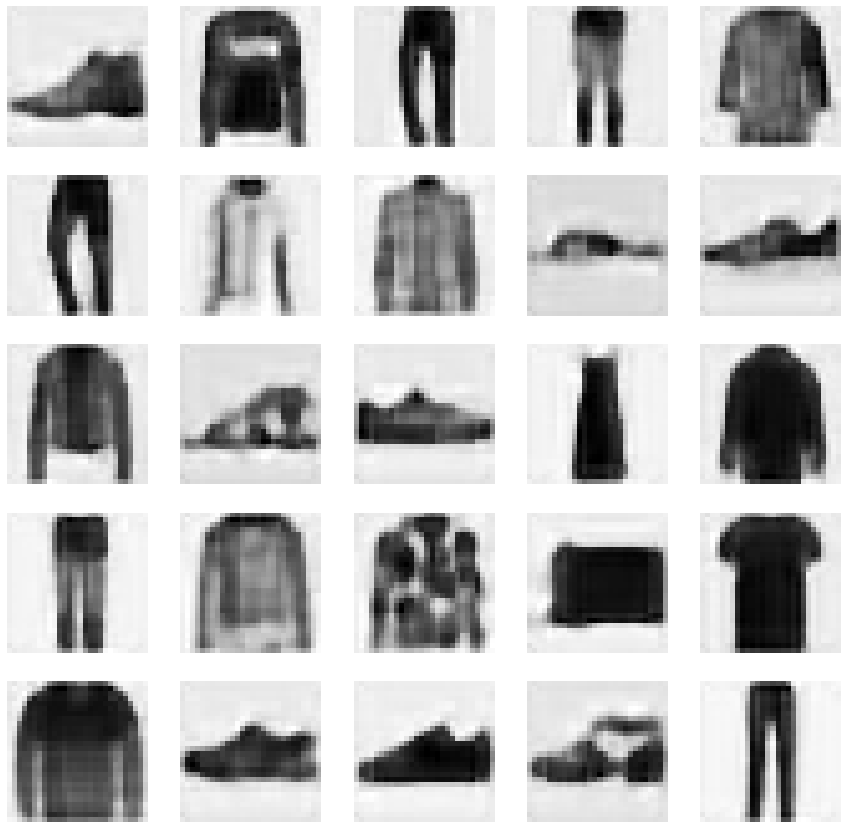

In [92]:
show_images(res[:25] * 2)

## try more channels, still descending

In [93]:
epochs=5
tmax = epochs * len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MetricsCB(), ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=get_model(channels=(32, 16, 4))
init_weights(model)
opt=partial(optim.Adam, eps=1e-5)

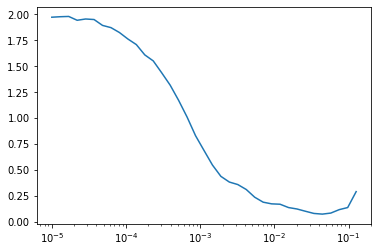

In [86]:
Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()

In [94]:
lr=3e-2

In [95]:
learn=Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt)

loss,epoch,train
0.092,0,train
0.018,0,eval
0.013,1,train
0.011,1,eval
0.008,2,train
0.007,2,eval
0.006,3,train
0.006,3,eval
0.006,4,train
0.006,4,eval


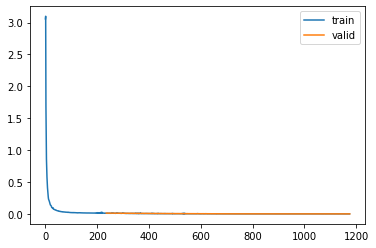

In [96]:
learn.fit(epochs)

In [97]:
res=model(xb.cuda()).cpu()

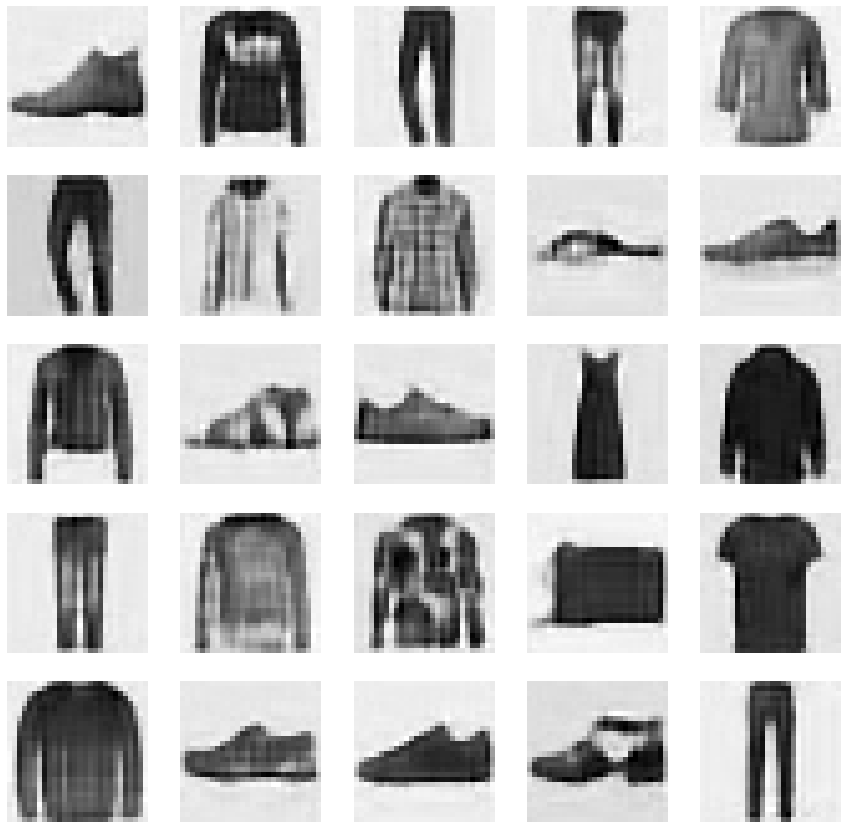

In [98]:
show_images(res[:25] * 2)

## do a lot of epochs and go to bed (just kidding, kill it so as not to keep paying for GPU, and try again tomorrow with classifier)

In [78]:
epochs=25
lr=3e-2
tmax = epochs * len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MetricsCB(), ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=get_model(channels=(32, 16, 4))
init_weights(model)
opt=partial(optim.Adam, eps=1e-5)

In [80]:
model.cuda()(xb.cuda()).shape

torch.Size([256, 1, 28, 28])

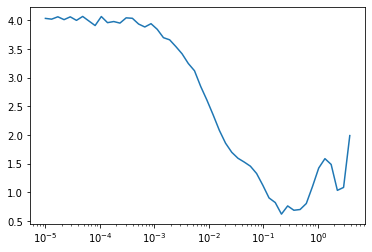

In [116]:
Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()

In [118]:
lr=3e-2

In [120]:
learn=Learner(model, dls, loss_func=nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt)

loss,epoch,train
0.982,0,train
0.383,0,eval
0.212,1,train
0.108,1,eval
0.069,2,train
0.046,2,eval
0.039,3,train
0.034,3,eval
0.031,4,train
0.029,4,eval


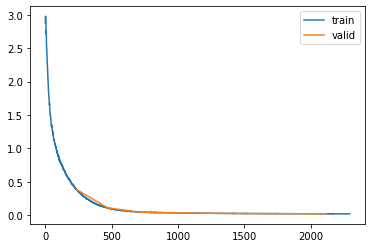

In [ ]:
learn.fit(epochs)

In [97]:
res=model(xb.cuda()).cpu()

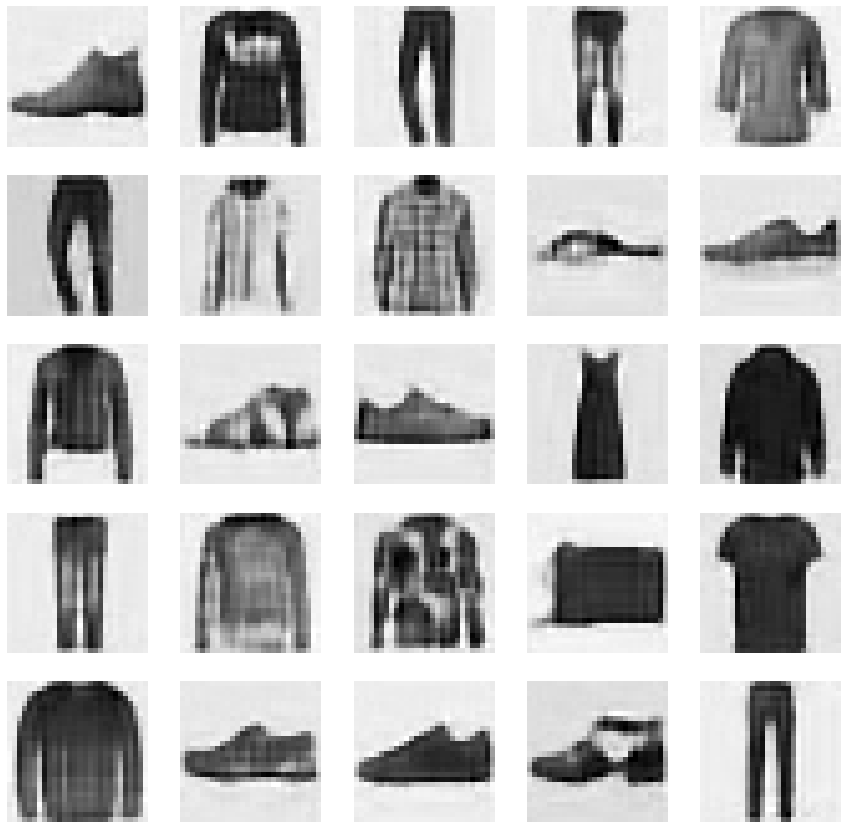

In [98]:
show_images(res[:25] * 2)

# Test with a classifier

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"

@inplace
def transformi_classifier(b): b[xl] = [(TF.to_tensor(o) - 0.5) for o in b[xl]]

tds_classifier = dsd.with_transform(transformi_classifier)
dls_classifier = DataLoaders.from_dd(tds_classifier, bs, num_workers=fc.defaults.cpus)

In [36]:
dsditer=iter(dsd['train'])

In [37]:
a=next(dsditer)

In [40]:
a['image']

In [41]:
a['label']

9

In [47]:
diter=iter(dls_classifier.train)
xb,yb=next(diter)
xb.shape, yb.shape, yb[:25]

(torch.Size([256, 1, 28, 28]),
 torch.Size([256]),
 tensor([5, 4, 5, 1, 4, 6, 9, 3, 6, 8, 1, 8, 4, 1, 8, 9, 7, 6, 3, 9, 0, 9, 2, 8, 4]))

In [27]:
yb[:25]

tensor([2, 6, 4, 9, 3, 1, 0, 9, 3, 2, 0, 8, 4, 0, 0, 2, 8, 6, 6, 9, 6, 6, 2, 2, 7])

In [25]:
dsd['train']['image'][0]

In [45]:
namels=dsd['train'].features['label'].names
list(enumerate(namels))

[(0, 'T - shirt / top'),
 (1, 'Trouser'),
 (2, 'Pullover'),
 (3, 'Dress'),
 (4, 'Coat'),
 (5, 'Sandal'),
 (6, 'Shirt'),
 (7, 'Sneaker'),
 (8, 'Bag'),
 (9, 'Ankle boot')]

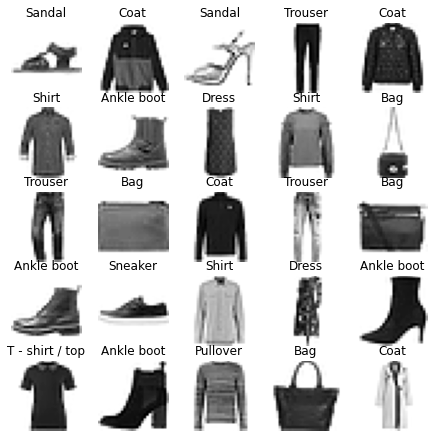

In [48]:
show_images(xb[:25], titles=[namels[i] for i in yb[:25]], imsize=1.5)

In [49]:
classifer_mdl = torch.load('models/jeremy-data_aug2.pkl')

In [50]:
classifer_mdl(xb.cuda()).shape

torch.Size([256, 10])

accuracy,loss,epoch,train
0.275,2.749,0,eval


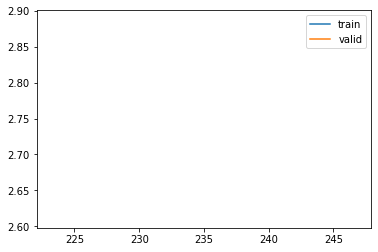

In [51]:
learn_classifier = Learner(classifer_mdl, dls_classifier, loss_func=F.cross_entropy, cbs=[DeviceCB(), MixedPrecision(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True)], opt_func=None)
with torch.no_grad():
    learn_classifier.fit(1, do_train=False, do_validate=True)

In [53]:
classifer_mdl.eval()
pred_yb = classifer_mdl(xb.cuda())
pred_yb.shape

torch.Size([256, 10])

In [57]:
pred_yb.argmax(1).shape

torch.Size([256])

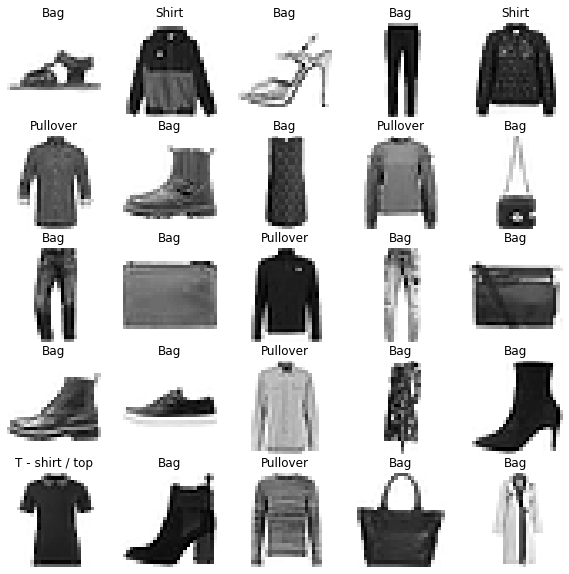

In [58]:
show_images(xb[:25], imsize=2, titles=[namels[i] for i in pred_yb[:25].argmax(1)])

In [60]:
init_weights??

Signature: init_weights(model, leaky=0.0)
Docstring: <no docstring>
Source:   
def init_weights(model, leaky=0.0):
    if isinstance(model, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(model.weight, a=leaky)
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/init.py
Type:      function


In [305]:
class mulv(nn.Module):
    def __init__(self, lat_sz):
        super().__init__()
        self.mu = lin(lat_sz, lat_sz)
        self.lv = lin(lat_sz, lat_sz)
    def forward(self, x):
        n, c, h, w = x.shape
        x=x.view(n, c * h * w)
        mu_x=self.mu(x)
        lv_x=self.lv(x)
        x = mu_x + (0.5 * lv_x).exp() * torch.randn(n, c * h * w, device=x.device)
        x = x.view(n, c, h, w)
        return x, mu_x, lv_x

In [283]:
class VAE2D(nn.Module):
    def __init__(self, act=act_genrelu, norm=nn.BatchNorm2d, drop=0.1):
        super().__init__()
        channels=(32,16, 4) 
        enc_layers = []
        n_layers=len(channels)
        enc_layers.append(ResBlock(1, channels[0], ks=3, stride=1, act=act, norm=norm))
        for i in range(n_layers - 1):
            enc_layers.append(ResBlock(channels[i], channels[i + 1], ks=3, stride=2, act=act, norm=norm))
            
        '''
        hardcoded vals for now. latents are size 4*7*7, will flatten for mu and lv
        '''
        lat_sz = 4*7*7
        enc_layers.append(mulv(lat_sz))
        self.enc = nn.Sequential(*enc_layers)
        
        dec_layers = []
        for i in range(n_layers - 1):
            dec_layers.append(upblock(channels[n_layers-1-i], channels[n_layers-i-2], ks=3, act=act, norm=norm))

        dec_layers.append(ResBlock(channels[0], 1, ks=3, stride=1, act=nn.Identity, norm=norm))
        self.dec = nn.Sequential(*dec_layers)
        init_weights(self)
    
    def forward(self, x):
        x, mu_x, lv_x = self.enc(x)
        return self.dec(x), mu_x, lv_x

In [331]:
class mulv_scratch(nn.Module):
    def __init__(self, lat_sz):
        super().__init__()
        self.mu = lin(lat_sz, lat_sz)
        self.lv = lin(lat_sz, lat_sz)
    def forward(self, x):
        mu_x=self.mu(x)
        lv_x=self.lv(x)
        x = mu_x + (0.5 * lv_x).exp() * torch.randn_like(x)
        return x, mu_x, lv_x

In [335]:
t=torch.ones((3,4,5))
nn.Flatten()(t).shape

torch.Size([3, 20])

In [388]:
class VAE2D_scratch(nn.Module):
    def __init__(self, act=act_genrelu, norm=nn.BatchNorm2d, drop=0.1):
        super().__init__()
        enc_layers=[]
        enc_layers.append(ResBlock(1, 32, stride=2, norm=norm))
        enc_layers.append(ResBlock(32, 64, stride=2, norm=norm))
        enc_layers.append(ResBlock(64, 64, stride=2, norm=norm))
        enc_layers.append(ResBlock(64, 64, stride=2, norm=norm))
        '''
        hardcoded vals, 28 halved three times to 3x3
        '''
        lat_sz = 64 * 2 * 2
        
        enc_layers.append(nn.Flatten())
        enc_layers.append(mulv_scratch(lat_sz))
        self.enc = nn.Sequential(*enc_layers)
        
        dec_layers = []
        dec_layers.append(upblock(64, 64, norm=norm))
        dec_layers.append(upblock(64, 64, norm=norm))
        dec_layers.append(upblock(64, 32, norm=norm))
        dec_layers.append(upblock(32, 1, act=nn.Identity, norm=norm))
        self.dec = nn.Sequential(*dec_layers)
        init_weights(self)
    
    def forward(self, x):
        orig_shape = x.shape
        x, mu_x, lv_x = self.enc(x)
        x= x.view(-1, 64, 2, 2)
        return self.dec(x), mu_x, lv_x

In [424]:
upblock??

Signature:
upblock(
    in_chans,
    out_chans,
    ks=3,
    act=functools.partial(<class 'diy_stable_diffusion.init.GeneralRelu'>, leak=0.1, sub=0.4),
    norm=None,
)
Docstring: <no docstring>
Source:   
def upblock(in_chans, out_chans, ks=3, act=act_genrelu, norm=None):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        ResBlock(in_chans, out_chans, ks=ks, act=act, norm=norm)
    )
File:      /tmp/ipykernel_457/3301647380.py
Type:      function


In [468]:
def simple_upconv(in_channels, out_channels):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        conv(in_channels, in_channels, stride=1),
        conv(in_channels, out_channels, stride=1)
    )

## now train vae
This code won't run now, I changed model definition to return mu and lv


In [491]:
def kdl_loss(inp, _):
    _, mu_x, lv_x = inp
    # var = (lv_x).exp()
    # return -0.5 * (1 + lv_x - mu_x**2 - var).mean()
    return -0.5 * (1 + lv_x - mu_x.pow(2) - lv_x.exp()).mean()

def bce_loss(inp, targets):
    return F.mse_loss(inp[0], targets)

def vae_combined_loss(inp, act_x):
    return kdl_loss(inp, act_x) + bce_loss(inp, act_x)

# Try vae with proper loss

In [178]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn
    
    def update(self, inp, targets):
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [226]:
def mse_tracker(inp, targs):
    return F.mse_loss(inp[0], targs)

In [244]:
def kdl_and_mse(inp, targ):
    return kdl_loss(inp, targ) + F.mse_loss(inp[0], targ)

In [487]:
bs=256
@inplace
def transformi(b):
    img = [F.pad(TF.to_tensor(o) - 0.5, (2, 2, 2, 2)) for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [488]:
dl = dls.valid
xb,yb = b = next(iter(dl))

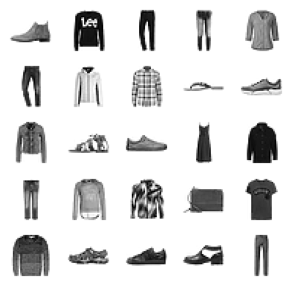

In [480]:
show_images(yb[:25],imsize=1.0)

kdl,bce,mse,loss,epoch,train
0.134,0.172,0.172,0.305,0,train
0.133,0.171,0.171,0.304,0,eval
0.134,0.172,0.172,0.305,1,train
0.133,0.171,0.171,0.304,1,eval
0.134,0.171,0.171,0.305,2,train
0.133,0.171,0.171,0.304,2,eval
0.134,0.172,0.172,0.305,3,train
0.133,0.171,0.171,0.304,3,eval
0.134,0.172,0.172,0.305,4,train
0.133,0.171,0.171,0.304,4,eval


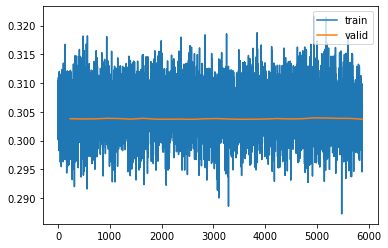

In [497]:
class SimpleVAE(nn.Module):
    def __init__(self, act=act_genrelu, norm=nn.BatchNorm2d, drop=0.1):
        super().__init__()
        self.conv1 = conv(1, 2, kernel_size=3)
        self.conv2 = conv(2, 3, kernel_size=3)
        
        self.flatten = nn.Flatten()
        lat_sz = 3 * 8 * 8
        self.mulv = mulv_scratch(lat_sz)
        
        self.dec_lin = lin(lat_sz, lat_sz)
        # self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
        # self.up2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2)
        self.up1 = simple_upconv(3, 2)
        self.up2 = simple_upconv(2, 1)
        self.apply(init_weights)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x, mux, lvx = self.mulv(x)
        x = self.dec_lin(x)
        x = x.view(x.shape[0], 3, 8, 8)
        x = self.up1(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.up2(x)
        return x, mux, lvx
        

'''
handles 32 x 32 images
'''
epochs=25
tmax = epochs * len(dls.train)
metrics=MetricsCB(kdl=FuncMetric(kdl_loss),bce=FuncMetric(bce_loss), mse=FuncMetric(mse_tracker))
# metrics=MetricsCB()
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision(), BatchSchedCB(sched)]
model=SimpleVAE().cuda()
init_weights(model)
opt=partial(optim.Adam, eps=1e-5)

#Learner(model, dls, loss_func=vae_combined_loss, lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()
# Learner(model, dls, loss_func=vae_combined_loss, lr=lr, cbs=[DeviceCB(), MixedPrecision()], opt_func=opt).lr_find()

lr=3e-2

learn=Learner(model, dls, loss_func=vae_combined_loss, lr=lr, cbs=cbs, opt_func=opt)

learn.fit(epochs)

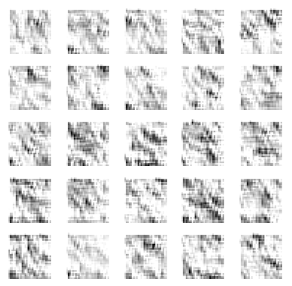

In [495]:
res,mux,lvx = model(xb.cuda())

show_images(res[:25].cuda(), imsize=1)

In [496]:
res.min(),res.max()

(tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<MinBackward1>),
 tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>))

In [401]:
lats, mux, lvx = model.enc(xb.cuda())

In [382]:
mux.shape

torch.Size([256, 256])

In [370]:
lats.shape

torch.Size([256, 256])

In [383]:
decoded_mus = model.dec(mux.view(-1, 64, 2, 2))

In [402]:
decoded_mus.mean(), mux.mean(), lvx.mean()

(tensor(-2.7715, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>),
 tensor(0.0051, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>),
 tensor(-0.0129, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

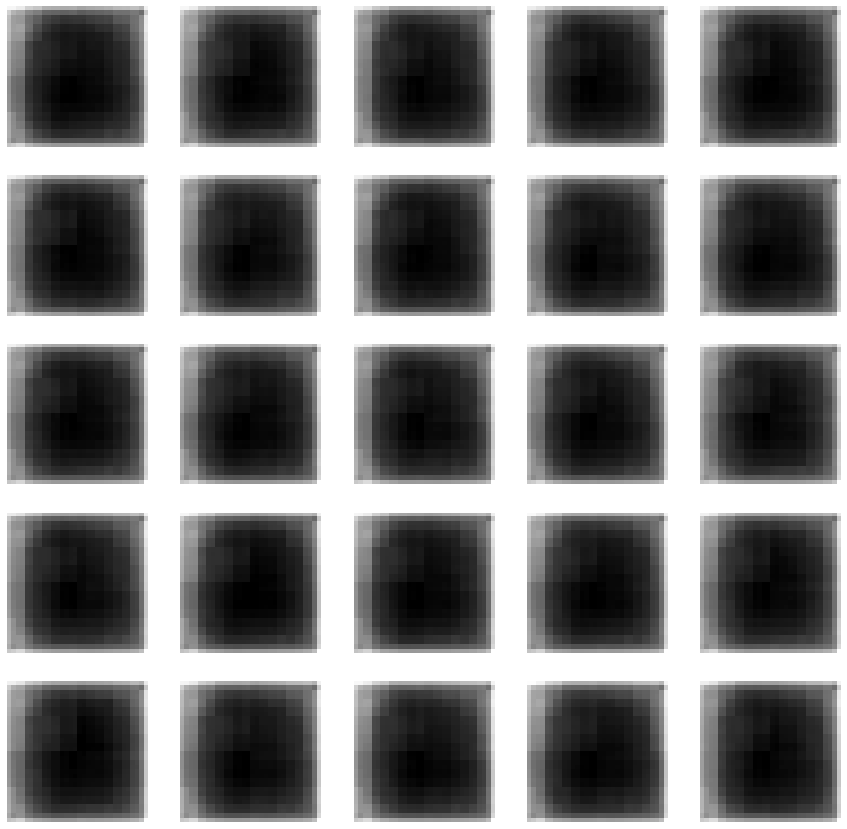

In [403]:
show_images(decoded_mus[:25].cpu())